In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import scipy as scp
from sklearn.decomposition import PCA
from sklearn import preprocessing

### Load data: features and stability scores

In [2]:
stab_sc = pd.DataFrame.from_csv('./final_stability_scores_all.csv')
features = pd.DataFrame.from_csv('./all_new_des_features_saved_regenerated.csv')
features.index = [i.split("_")[0] for i in features.index]
des_with_features_and_stab_sc = []
for i in features.index:
    if i in stab_sc.index:
        des_with_features_and_stab_sc.append(i)
features_clean = pd.concat([features.loc[des_with_features_and_stab_sc],stab_sc.loc[des_with_features_and_stab_sc]], axis=1)
features_clean.to_csv('./final_features_and_stab_sc.csv')

/software/conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/software/conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


### Set up for training 

In [3]:
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV,ElasticNet,Lasso
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import scale, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [4]:
BB_df = features_clean
terms_given_C={}
allterms = [i for i in BB_df.columns if (i !='stability_sc') ]
scaler = StandardScaler()
scaler.fit(BB_df[allterms])
X=scaler.transform(BB_df[allterms])
y = [ x >= 1.5 for x in BB_df['stability_sc'].values]

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [5]:
# List of regularization constants for Lasso:
Cs = [0.05, 0.045,0.04, 0.035,0.03, 0.025,0.02,0.01,0.008,0.005,0.0048,0.004]

result_summary = {}
for C in Cs:
    result_summary[C] = {}
    for randstate in range(40):
        # Make a different split each time:
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=randstate)
        clf = LogisticRegression(C=C,penalty='l1',class_weight='balanced',random_state=1,solver='liblinear')
        clf.fit(X_train,y_train)
        #C_lists.append(C)
        
        train_proba = [x[1] for x in clf.predict_proba(X_train)]
        test_proba = [x[1] for x in clf.predict_proba(X_test)]
        fpr,tpr,thresholds=roc_curve(y_train,train_proba)
        #plt.plot(fpr,tpr,label=C)
        
        
        terms_n = sum([x != 0 for x in clf.coef_[0]])
        train_auc = roc_auc_score(y_train,train_proba)
        test_auc = roc_auc_score(y_test,test_proba)
        train_score = clf.score(X_train,y_train)
        test_score = clf.score(X_test,y_test)
        train_accuracy = recall_score(y_train,clf.predict(X_train))
        test_accuracy = recall_score(y_test,clf.predict(X_test))
        #print ('C=%s  terms:%s  train_auc=%.3f test_auc=%.3f score_train=%.3f score_test=%.3f, train_acc=%.3f, test_acc=%.3f' %(C,terms_n,train_auc,test_auc,train_score,test_score,train_accuracy,test_accuracy))
        result_summary[C][randstate] = {'test_score':test_score,'test_accuracy':test_accuracy,\
                                        'train_score':train_score,'train_accuracy':train_accuracy,\
                                       'test_auc':test_auc,'train_auc':train_auc,'non_zero_terms':[]}
        
        for coef, term in zip(clf.coef_[0], allterms):
            if coef != 0.0: result_summary[C][randstate]['non_zero_terms'].append((coef,term))

### Plot results

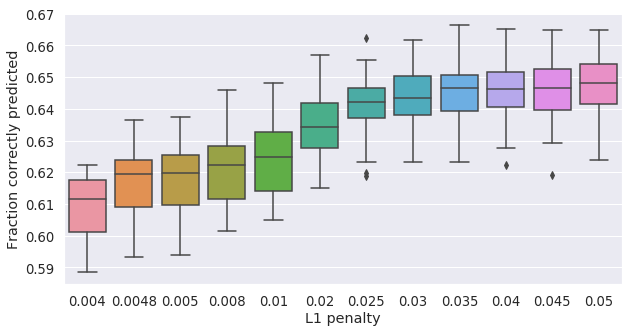

In [6]:
C_vals = sorted([i for i in result_summary.keys()])
C_20_vals = []
test_scores = []
train_scores = []
test_auc_list = []
train_auc_list = []
for i in C_vals:
    for j in range(20):
        C_20_vals.append(i)
        test_scores.append(result_summary[i][j]['test_score'])
        train_scores.append(result_summary[i][j]['train_score'])
        test_auc_list.append(result_summary[i][j]['test_auc'])
        train_auc_list.append(result_summary[i][j]['train_auc'])

sns.set(font_scale=1.2)
fig1,ax1= plt.subplots(1,figsize=(10,5))
#sns.boxplot(np.array(C_20_vals),np.array(test_auc_list))
#plt.legend()
#plt.show()
sns.boxplot(np.array(C_20_vals),np.array(test_scores),ax=ax1)
ax1.set_xlabel('L1 penalty')
ax1.set_ylabel('Fraction correctly predicted')
plt.show()

### Get simplest model
Looks like around L1=0.01 the model performance reaches a plateau, so we are going to look for the simplest model at that value that has a score within one standard deviation of the mean for models with that L1

In [7]:
for i in range(40):
    print(i,len(result_summary[0.01][i]['non_zero_terms']),result_summary[0.01][i]['test_score'])
print('Average n features: %d'%(np.average([len(result_summary[0.01][i]['non_zero_terms']) for i in range(40)])))

0 12 0.6127508854781583
1 15 0.6050767414403778
2 9 0.6481700118063755
3 11 0.6239669421487604
4 11 0.6257378984651711
5 14 0.6086186540731995
6 11 0.6304604486422668
7 11 0.640495867768595
8 12 0.6227863046044865
9 10 0.6239669421487604
10 10 0.6316410861865407
11 11 0.614521841794569
12 12 0.6357733175914995
13 13 0.6121605667060213
14 14 0.6263282172373081
15 12 0.6351829988193625
16 10 0.6316410861865407
17 14 0.6133412042502951
18 13 0.6381345926800472
19 10 0.6168831168831169
20 14 0.6103896103896104
21 13 0.6239669421487604
22 12 0.6115702479338843
23 14 0.6157024793388429
24 10 0.614521841794569
25 13 0.6180637544273908
26 11 0.6180637544273908
27 10 0.614521841794569
28 11 0.6038961038961039
29 11 0.6109799291617474
30 13 0.6174734356552538
31 13 0.6257378984651711
32 10 0.6198347107438017
33 11 0.6157024793388429
34 13 0.6221959858323495
35 15 0.6269185360094451
36 11 0.6157024793388429
37 10 0.602125147579693
38 11 0.6180637544273908
39 11 0.6204250295159386
Average n featur

In [8]:
# The simplest model is random partition=16, lets look at it:
for i in sorted(result_summary[0.01][2]['non_zero_terms'],key=lambda x:abs(x[0]),reverse=True):
    print(i)

(0.2503760145072562, 'hphob_sc_contacts')
(0.15339188539101647, 'BuriedHyphobSAperRes')
(0.1315369407788653, 'dsc_av')
(-0.10118747375036977, 'score_res_betacart')
(0.04340037202879755, 'HolesCorSAS')
(-0.0346345649623529, 'buns_nosurf_sc')
(-0.030195236879252275, 'av_all_strand')
(-0.02464256149861897, 'loop3_flank_av_worstfr')
(0.0117546294879386, 'tryp_cut_sites')


### Get feature importance

In [9]:
terms = []
for i in range(40):
    for j in result_summary[0.01][i]['non_zero_terms']:
        terms.append(j[1])

didt_for_df = {i:{ j:0 for j in terms} for i in range(40)}
        
for i in range(40):
    for j in result_summary[0.01][i]['non_zero_terms']:
        didt_for_df[i][j[1]] = j[0]
        #didt_for_df[i][j[1]] = abs(j[0])

models_df = pd.DataFrame.from_dict(didt_for_df,orient='index')

/software/conda/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


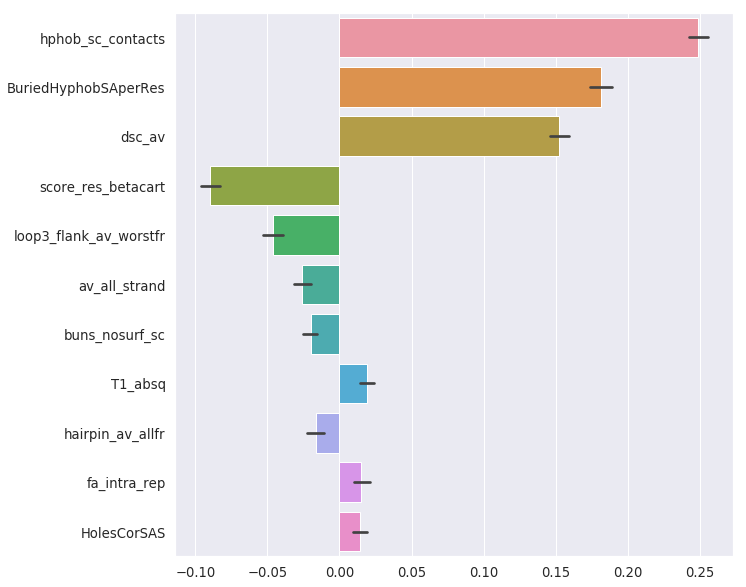

In [10]:
fig2,ax2= plt.subplots(1,figsize=(10,10))
sorted_terms_by_av = sorted( [(t,abs(np.average(models_df[t]))) for t in set(terms)], key=lambda x:x[1]  )
top_15_terms = [i for i in reversed([t[0] for t in sorted_terms_by_av][-11:])]
sns.barplot(data=models_df[top_15_terms],orient='h',ax=ax2)
#ax2.set_xlabel('Features')
#ax2.set_ylabel('Weight absolute value')
plt.show()

### Get correlation matrix for simplest model

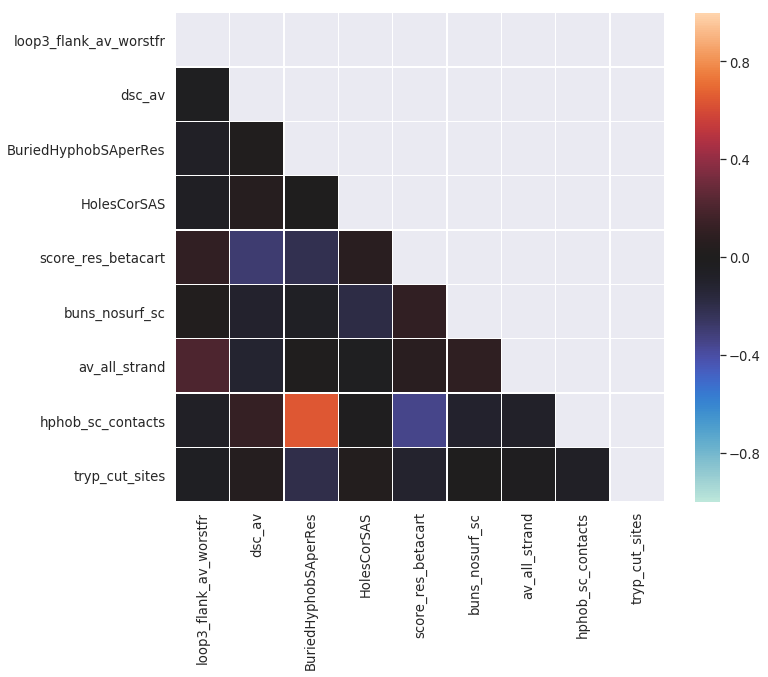

In [11]:
simplest_model_features = [i[1] for i in result_summary[0.01][2]['non_zero_terms']]
specific_df = features_clean[simplest_model_features]
corr = specific_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5)

### Get correlation matrix for 15 most important features in all (40) models

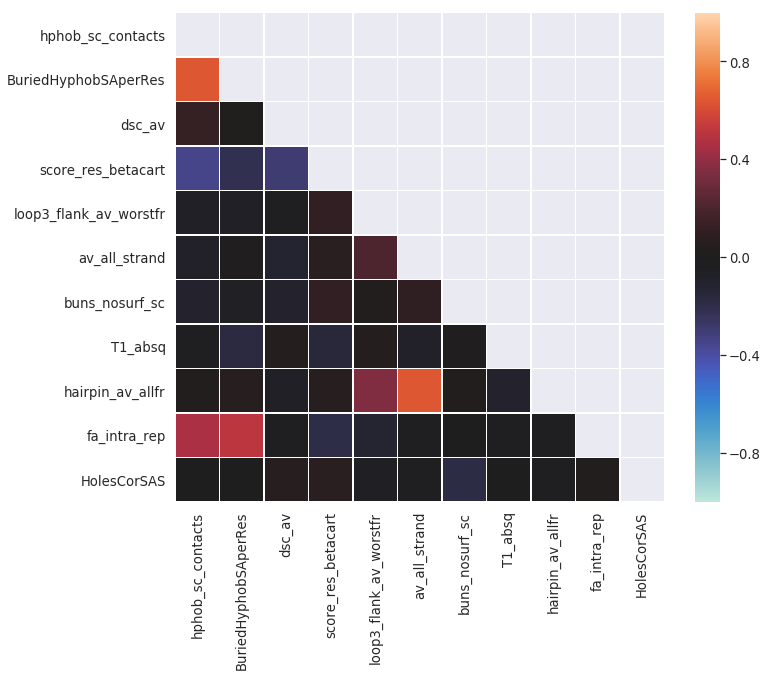

In [12]:
specific_df = features_clean[top_15_terms]
corr = specific_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5)

### What are the less complex models at L1=0.008?

In [13]:
for i in range(40):
    print(i,len(result_summary[0.008][i]['non_zero_terms']),result_summary[0.008][i]['test_score'])
print('Average n features: %d'%(np.average([len(result_summary[0.008][i]['non_zero_terms']) for i in range(40)])))

0 10 0.6080283353010626
1 8 0.601534828807556
2 8 0.6458087367178277
3 8 0.6127508854781583
4 8 0.627508854781582
5 10 0.60271546635183
6 7 0.6210153482880756
7 9 0.6310507674144038
8 7 0.6233766233766234
9 7 0.6186540731995277
10 7 0.6310507674144038
11 9 0.6133412042502951
12 8 0.6334120425029516
13 11 0.6033057851239669
14 8 0.6257378984651711
15 8 0.6263282172373081
16 8 0.6245572609208973
17 10 0.6056670602125147
18 8 0.6322314049586777
19 5 0.6133412042502951
20 9 0.6074380165289256
21 9 0.6233766233766234
22 9 0.6097992916174735
23 10 0.6162927981109799
24 10 0.6086186540731995
25 9 0.6121605667060213
26 8 0.6174734356552538
27 8 0.614521841794569
28 7 0.5997638724911453
29 7 0.6097992916174735
30 11 0.6080283353010626
31 11 0.6227863046044865
32 7 0.6174734356552538
33 9 0.6109799291617474
34 8 0.6127508854781583
35 9 0.6216056670602125
36 6 0.6157024793388429
37 6 0.6044864226682408
38 8 0.6121605667060213
39 7 0.6127508854781583
Average n features: 8


In [14]:
# The simplest model is random partition=4, lets look at it:
for i in sorted(result_summary[0.008][19]['non_zero_terms'],key=lambda x:abs(x[0]),reverse=True):
    print(i)

(0.2612180043436904, 'hphob_sc_contacts')
(0.1493046060011746, 'dsc_av')
(0.11777636963343732, 'BuriedHyphobSAperRes')
(-0.09476009383762879, 'score_res_betacart')
(-0.020950371799048326, 'av_all_strand')
